# MLP, GCN, and GAT models using PyTorch Geometric for CiteSeer node classification

- Imports, including `GCNConv` and `GATConv` from `torch_geometric`.
- Download `CiteSeer` dataset. Dataset info (number of graphs, nodes, edges, node classes, node features, etc.)
- Force-directed visualization of the graph.
- MLP model for node classification.
- t-SNE visualization of initial node embeddings (just a random mess, as expected).
- Train and test MLP model. Final test acc ~57%.
- t-SNE visualization of node embeddings of trained MLP model (showing better separation).
- Two-layer GCN model for node classification. Train and test model. Final test acc ~70%. t-SNE visualization of node embeddings of trained GCN model.
- Two-layer GAT model for node classification. Train and test model. Final test acc ~72%. t-SNE visualization of node embeddings of trained GAT model.

### Imports

In [65]:
import matplotlib.pyplot as plt
from IPython.display import Image

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_networkx, degree
from torch_geometric.datasets import Planetoid

from collections import Counter

import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

### Dataset info

In [32]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer')
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


In [33]:
data = dataset[0]  # Get the first graph object.
print(data)
print('================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [34]:
deg = degree(data.edge_index[0], data.num_nodes, dtype=torch.float)

deg_counts = Counter(deg.tolist()) 
deg_counts = sorted(deg_counts.items(), key=lambda x: x[0])
deg_counts

[(0.0, 48),
 (1.0, 1331),
 (2.0, 795),
 (3.0, 438),
 (4.0, 237),
 (5.0, 139),
 (6.0, 110),
 (7.0, 61),
 (8.0, 33),
 (9.0, 24),
 (10.0, 30),
 (11.0, 19),
 (12.0, 17),
 (13.0, 4),
 (14.0, 3),
 (15.0, 9),
 (16.0, 7),
 (17.0, 4),
 (18.0, 2),
 (19.0, 2),
 (20.0, 1),
 (21.0, 2),
 (22.0, 1),
 (23.0, 2),
 (27.0, 1),
 (28.0, 1),
 (29.0, 1),
 (30.0, 1),
 (34.0, 1),
 (35.0, 1),
 (51.0, 1),
 (99.0, 1)]

### Force-directed drawing of graph

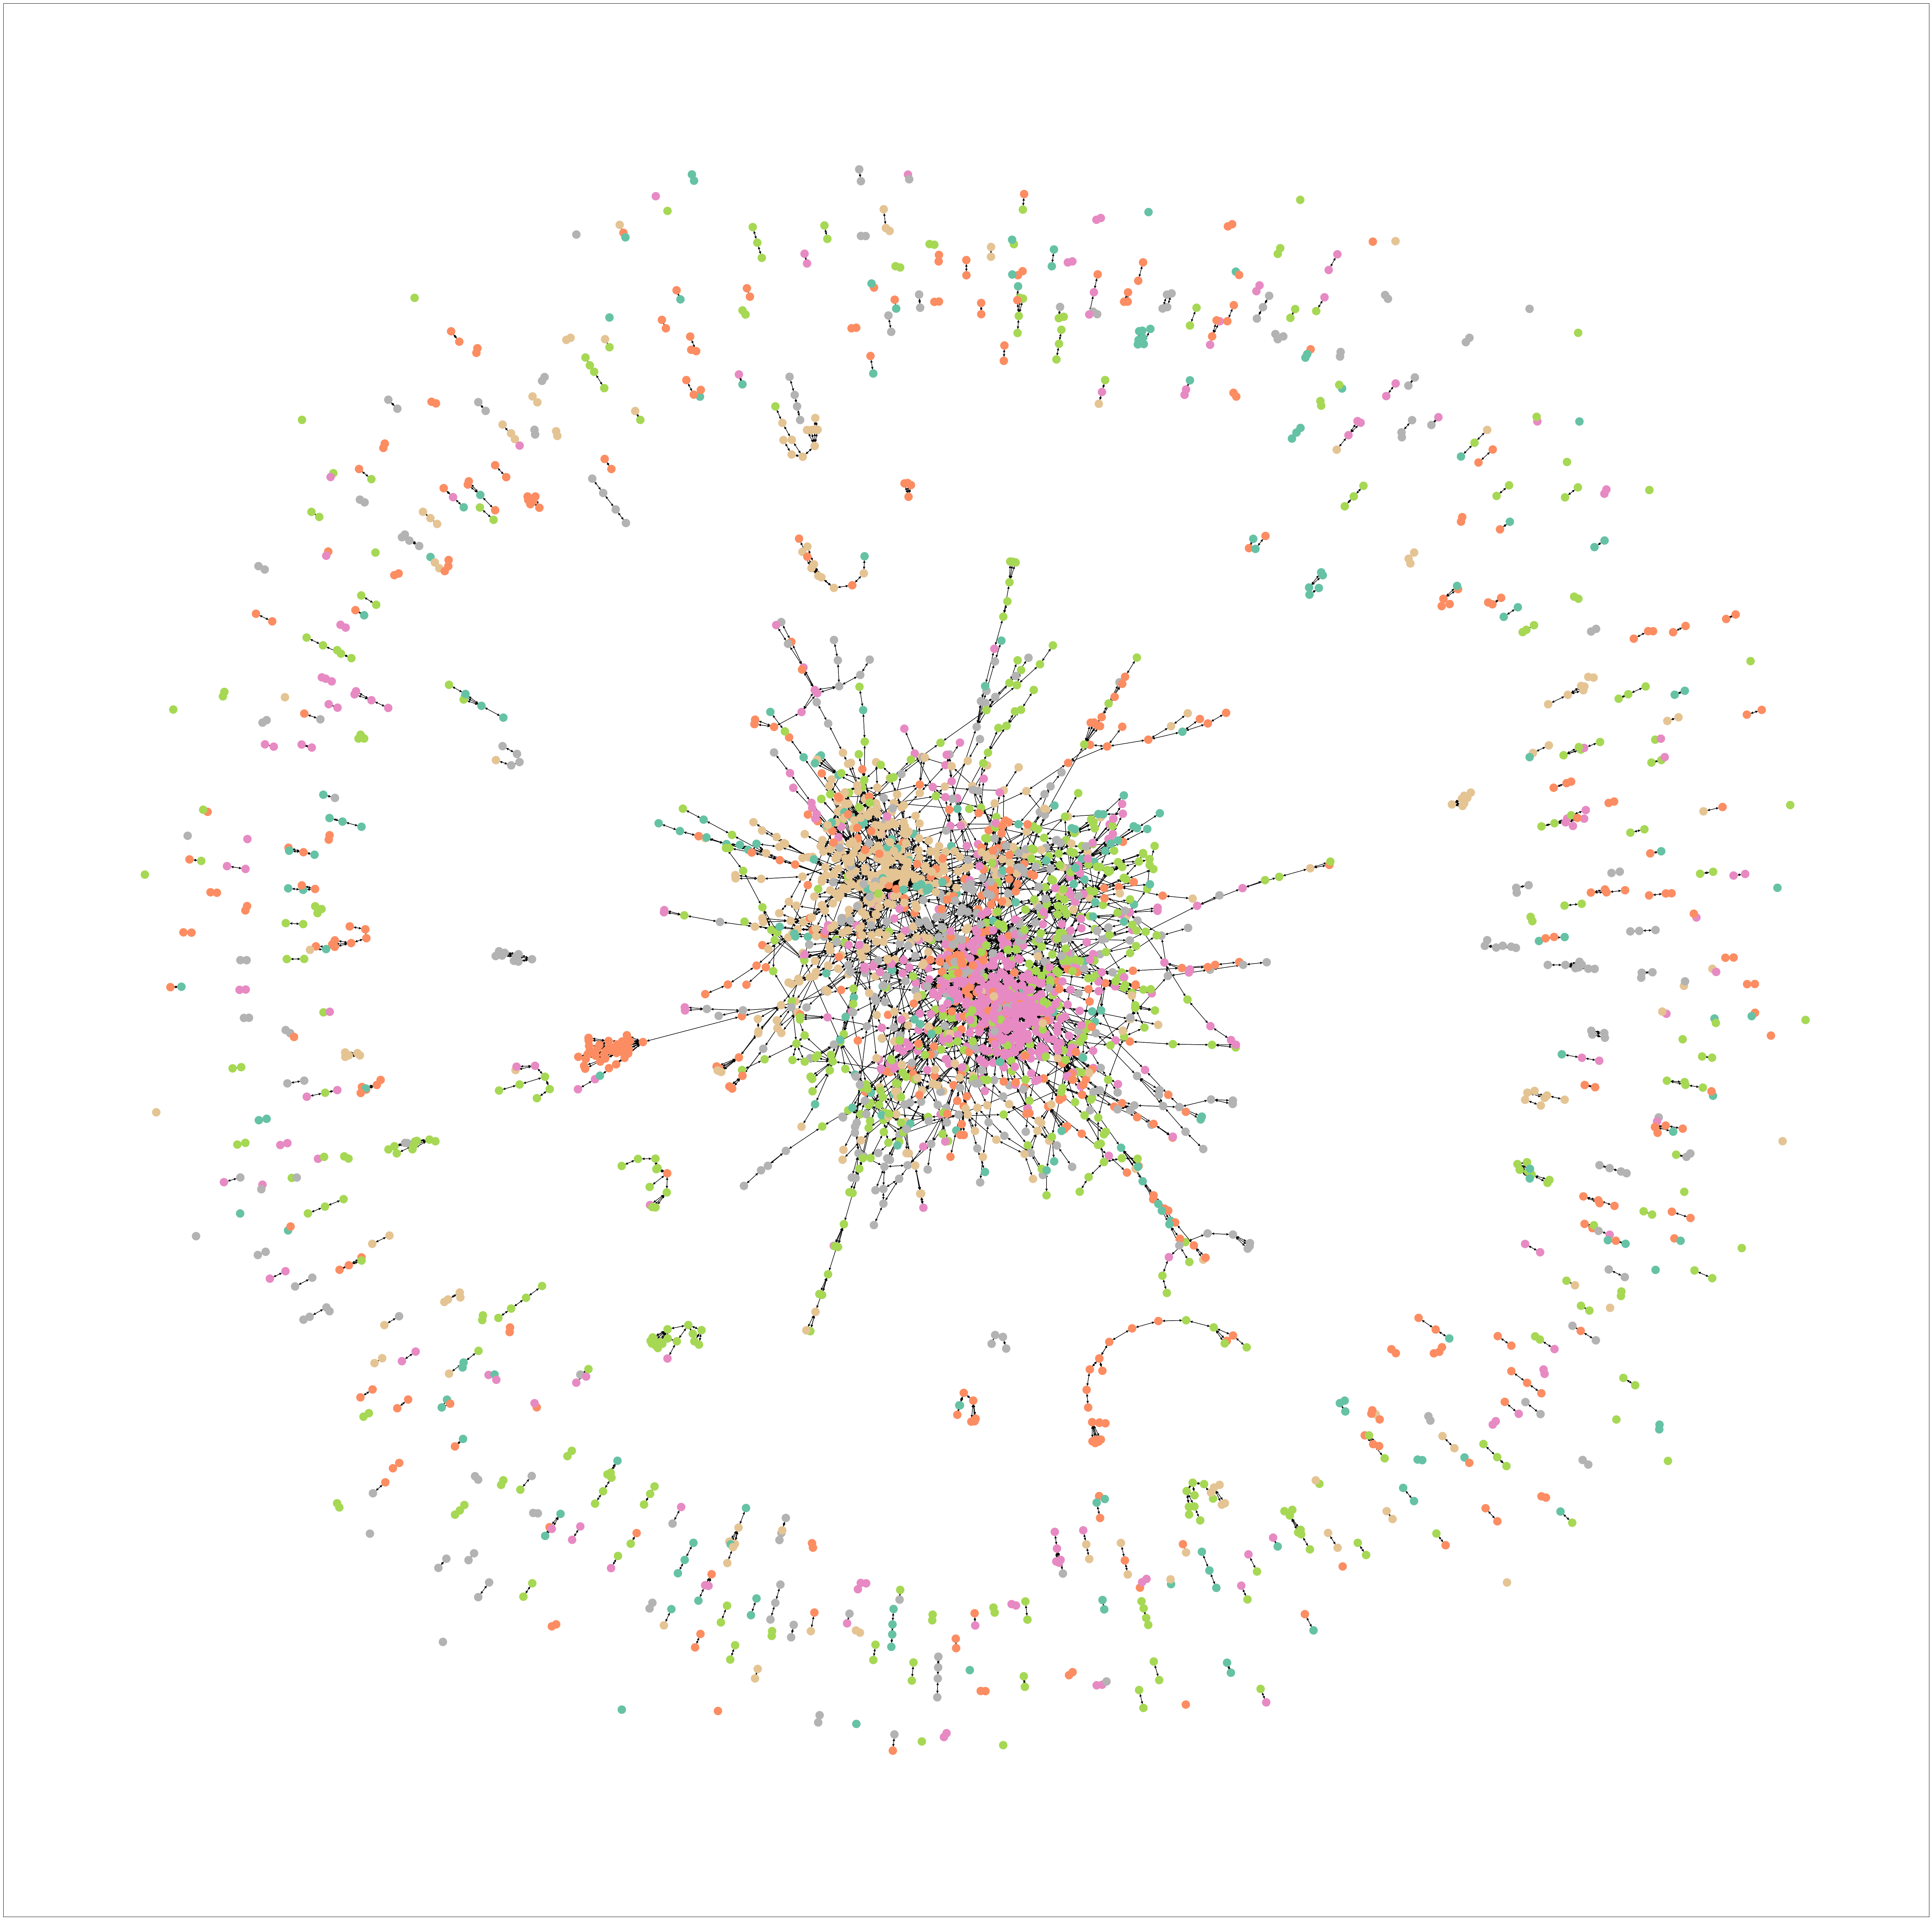

In [35]:
def visualize_graph(G, color):
    plt.figure(figsize=(75,75))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G, pos=nx.spring_layout(G), with_labels=False, 
        node_color=color, cmap="Set2")
    plt.show()

G = to_networkx(data)

#visualize_graph(G, color=data.y)
Image('images/citeseer-visualization.png')


### MLP for node classification

In [36]:
class MLP(nn.Module):

    def __init__(self, hidden_channels):
        super().__init__()
        self.linear1 = nn.Linear(dataset.num_features, hidden_channels) 
        self.linear2 = nn.Linear(hidden_channels, dataset.num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        return x

In [37]:
mlp = MLP(hidden_channels=16)
print(mlp)

MLP(
  (linear1): Linear(in_features=3703, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=6, bias=True)
  (relu): ReLU()
)


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(mlp):,} trainable parameters')

The model has 59,366 trainable parameters


### t-SNE visualization of initial node embeddings

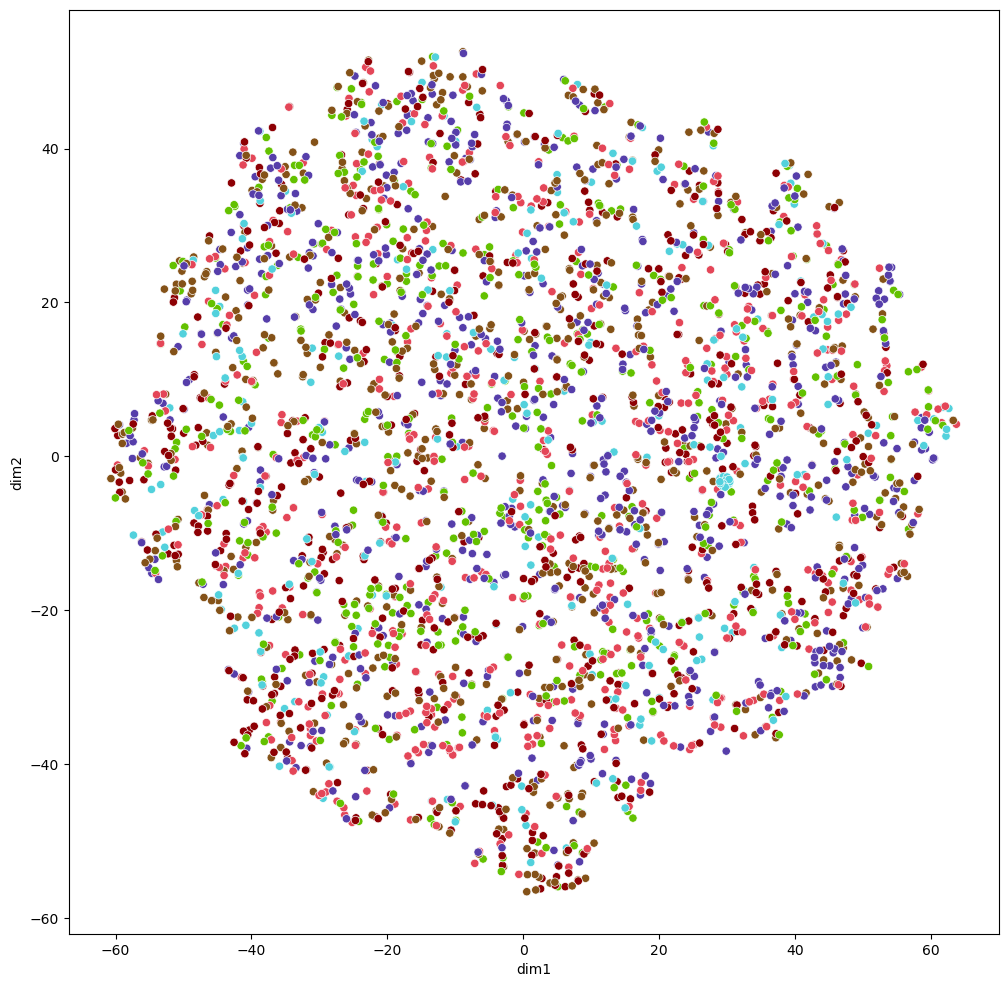

In [39]:
def visualize(data, labels):
    tsne = TSNE(n_components=2, init='pca', random_state=7)
    tsne_res = tsne.fit_transform(data)
    v = pd.DataFrame(data,columns=[str(i) for i in range(data.shape[1])])
    v['color'] = labels
    v['label'] = v['color'].apply(lambda i: str(i))
    v["dim1"] = tsne_res[:,0]
    v["dim2"] = tsne_res[:,1]
    plt.figure(figsize=(12,12))
    sns.scatterplot(
        x="dim1", y="dim2",
        hue="color",
        palette=sns.color_palette(
            ["#52D1DC", "#8D0004", "#845218","#563EAA", 
             "#E44658", "#63C100"]),
        legend=False,
        data=v,
    )

mlp.eval()
out = mlp(data.x)
visualize(out.detach().cpu().numpy(), data.y)

### Train and test MLP model

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(16).to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
loss_fn = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

for epoch in range(100):
    loss = train()
    train_acc = test(data.train_mask)
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 1.7989, Train Acc: 0.2833, Val Acc: 0.2220, Test Acc: 0.2380
Epoch: 001, Loss: 1.7295, Train Acc: 0.3750, Val Acc: 0.2220, Test Acc: 0.2370
Epoch: 002, Loss: 1.6413, Train Acc: 0.5750, Val Acc: 0.2420, Test Acc: 0.2460
Epoch: 003, Loss: 1.5199, Train Acc: 0.6917, Val Acc: 0.2800, Test Acc: 0.2840
Epoch: 004, Loss: 1.4211, Train Acc: 0.8000, Val Acc: 0.3160, Test Acc: 0.3170
Epoch: 005, Loss: 1.2977, Train Acc: 0.8500, Val Acc: 0.3400, Test Acc: 0.3420
Epoch: 006, Loss: 1.2385, Train Acc: 0.9250, Val Acc: 0.3900, Test Acc: 0.3790
Epoch: 007, Loss: 1.0637, Train Acc: 0.9750, Val Acc: 0.4500, Test Acc: 0.4100
Epoch: 008, Loss: 0.9674, Train Acc: 0.9833, Val Acc: 0.4760, Test Acc: 0.4350
Epoch: 009, Loss: 0.9509, Train Acc: 1.0000, Val Acc: 0.4760, Test Acc: 0.4330
Epoch: 010, Loss: 0.8208, Train Acc: 1.0000, Val Acc: 0.4880, Test Acc: 0.4480
Epoch: 011, Loss: 0.6715, Train Acc: 1.0000, Val Acc: 0.4920, Test Acc: 0.4560
Epoch: 012, Loss: 0.6295, Train Acc: 1.0000, Val Acc

### t-SNE visualization of node embeddings of trained MLP model

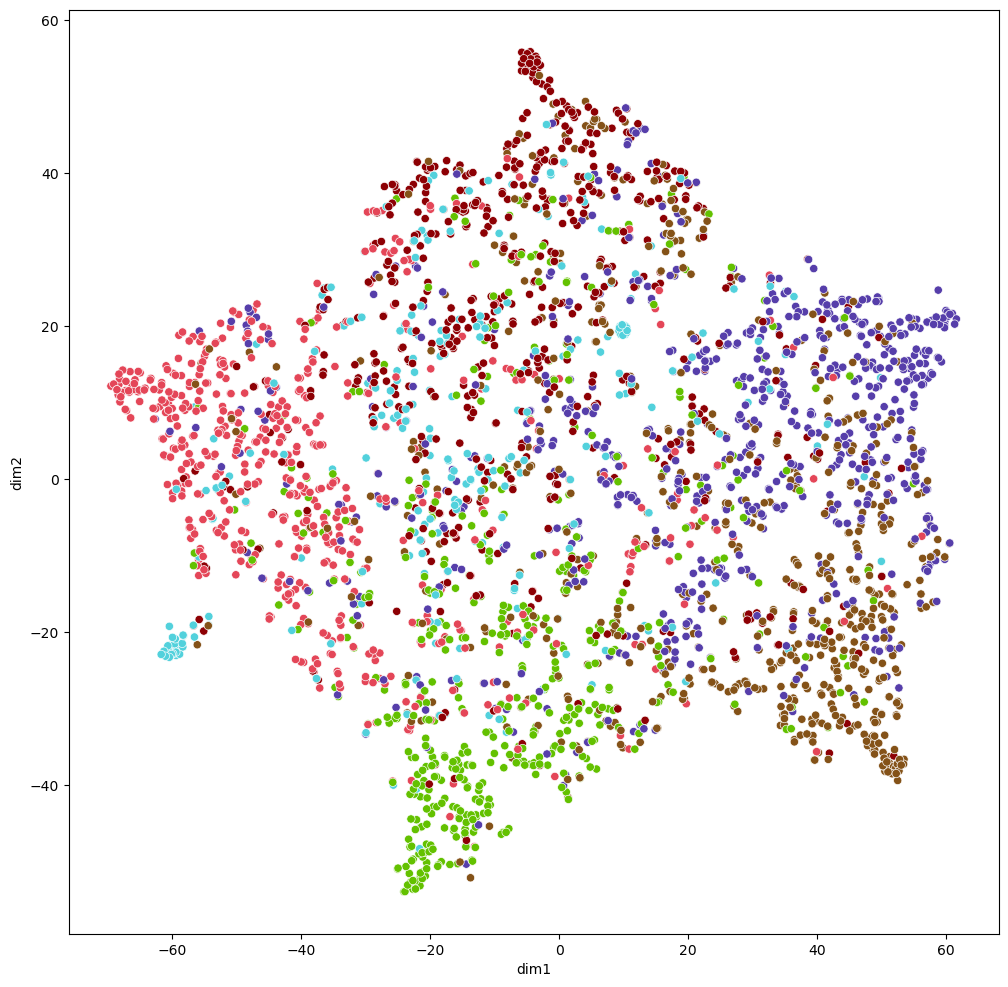

In [43]:
out = model(data.x)
visualize(out.detach().cpu().numpy(), data.y)

### GCN for node classification

In [46]:
class GCN(nn.Module):

    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [47]:
gcn = GCN(hidden_channels=16)
print(gcn)

GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)


In [48]:
print(f'The model has {count_parameters(gcn):,} trainable parameters')

The model has 59,366 trainable parameters


In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(16).to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
loss_fn = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

for epoch in range(100):
    loss = train()
    train_acc = test(data.train_mask)
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 1.7957, Train Acc: 0.7000, Val Acc: 0.4860, Test Acc: 0.4180
Epoch: 001, Loss: 1.6518, Train Acc: 0.8833, Val Acc: 0.5920, Test Acc: 0.5660
Epoch: 002, Loss: 1.4437, Train Acc: 0.9250, Val Acc: 0.6460, Test Acc: 0.6360
Epoch: 003, Loss: 1.2201, Train Acc: 0.9333, Val Acc: 0.6420, Test Acc: 0.6340
Epoch: 004, Loss: 1.0254, Train Acc: 0.9500, Val Acc: 0.6420, Test Acc: 0.6310
Epoch: 005, Loss: 0.8652, Train Acc: 0.9417, Val Acc: 0.6460, Test Acc: 0.6480
Epoch: 006, Loss: 0.6905, Train Acc: 0.9417, Val Acc: 0.6660, Test Acc: 0.6730
Epoch: 007, Loss: 0.6082, Train Acc: 0.9417, Val Acc: 0.6760, Test Acc: 0.6840
Epoch: 008, Loss: 0.5473, Train Acc: 0.9667, Val Acc: 0.6880, Test Acc: 0.6930
Epoch: 009, Loss: 0.4532, Train Acc: 0.9833, Val Acc: 0.6900, Test Acc: 0.7000
Epoch: 010, Loss: 0.3723, Train Acc: 0.9750, Val Acc: 0.6860, Test Acc: 0.6980
Epoch: 011, Loss: 0.3534, Train Acc: 0.9833, Val Acc: 0.6880, Test Acc: 0.6960
Epoch: 012, Loss: 0.2997, Train Acc: 0.9833, Val Acc

### t-SNE visualization of node embeddings of trained GCN model

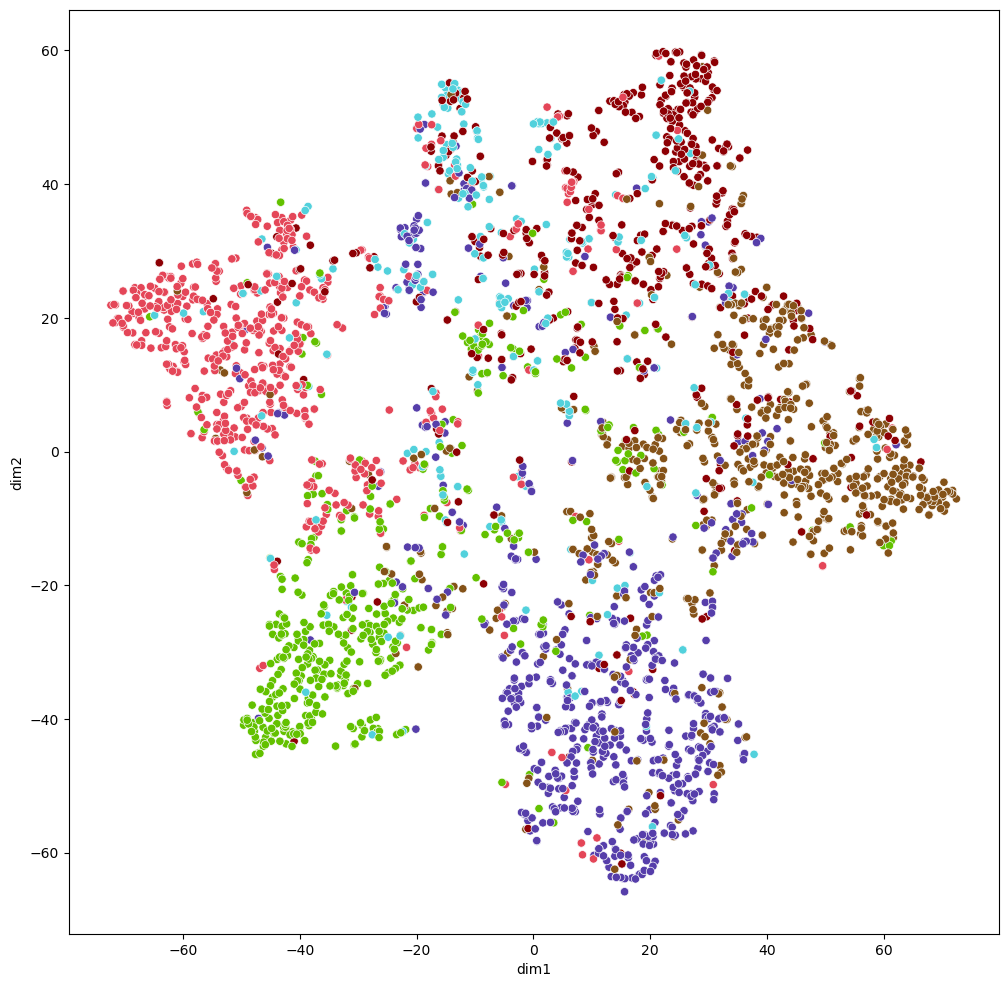

In [62]:
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

### GAT model for node classification

In [66]:
class GAT(nn.Module):

    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, 
                        hidden_channels, 
                        heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, 
                        dataset.num_classes, 
                        heads=1)
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [67]:
gat = GAT(hidden_channels=16, heads=8)
print(gat)

GAT(
  (conv1): GATConv(3703, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


In [68]:
print(f'The model has {count_parameters(gat):,} trainable parameters')

The model has 475,154 trainable parameters


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(hidden_channels=16, heads=8).to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-1)
loss_fn = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

for epoch in range(100):
    loss = train()
    train_acc = test(data.train_mask)
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 1.7987, Train Acc: 0.1833, Val Acc: 0.1380, Test Acc: 0.1390
Epoch: 001, Loss: 1.7838, Train Acc: 0.2250, Val Acc: 0.1600, Test Acc: 0.1650
Epoch: 002, Loss: 1.7760, Train Acc: 0.2583, Val Acc: 0.1780, Test Acc: 0.1920
Epoch: 003, Loss: 1.7624, Train Acc: 0.3333, Val Acc: 0.2000, Test Acc: 0.2280
Epoch: 004, Loss: 1.7642, Train Acc: 0.4000, Val Acc: 0.2200, Test Acc: 0.2610
Epoch: 005, Loss: 1.7503, Train Acc: 0.4667, Val Acc: 0.2640, Test Acc: 0.2950
Epoch: 006, Loss: 1.7429, Train Acc: 0.5250, Val Acc: 0.3160, Test Acc: 0.3220
Epoch: 007, Loss: 1.7246, Train Acc: 0.5583, Val Acc: 0.3420, Test Acc: 0.3430
Epoch: 008, Loss: 1.7405, Train Acc: 0.6250, Val Acc: 0.3620, Test Acc: 0.3650
Epoch: 009, Loss: 1.7286, Train Acc: 0.6833, Val Acc: 0.3820, Test Acc: 0.3870
Epoch: 010, Loss: 1.7257, Train Acc: 0.7583, Val Acc: 0.4100, Test Acc: 0.4080
Epoch: 011, Loss: 1.7124, Train Acc: 0.8083, Val Acc: 0.4260, Test Acc: 0.4310
Epoch: 012, Loss: 1.6965, Train Acc: 0.8250, Val Acc

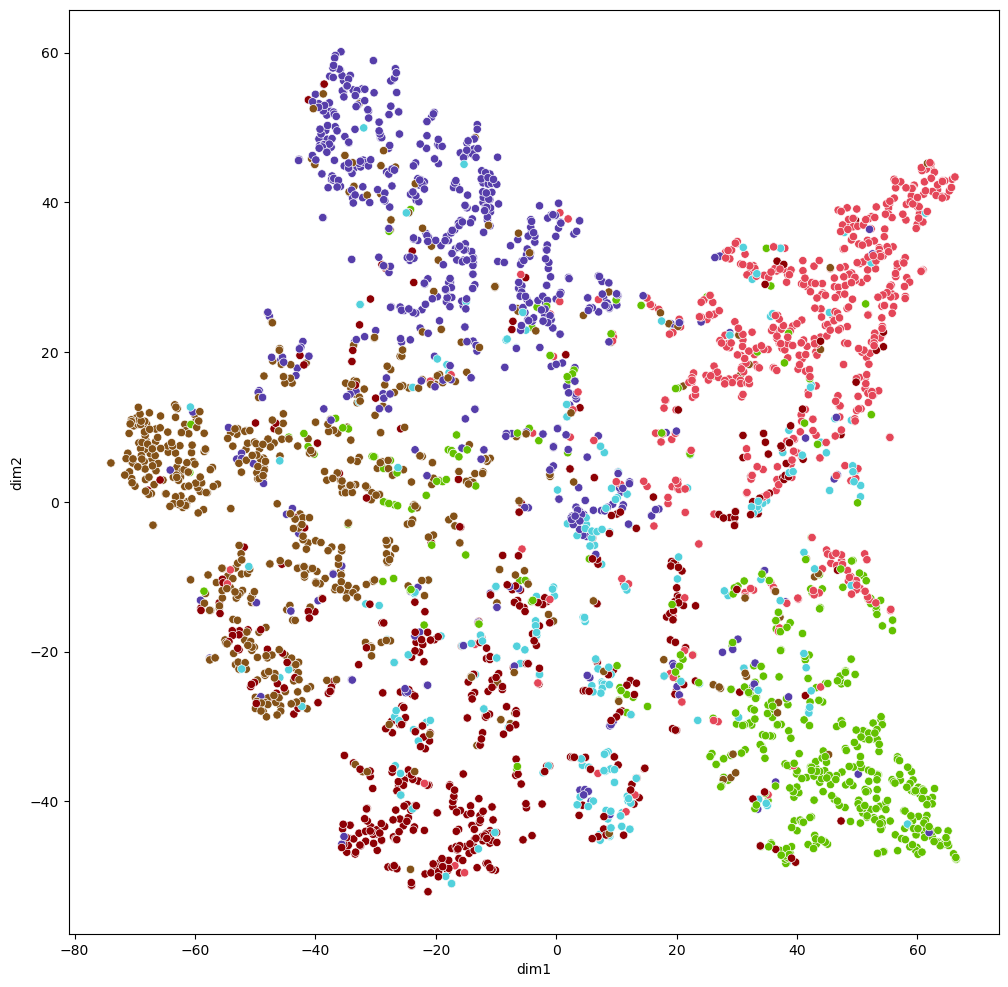

In [70]:
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)